In [3]:
"""
Probably gonna need to update this in future.
"""

objectInfoDict={'m82'     :{'redshift'    :0.000677,
                            'centerCoo'   :(148.9667,69.6794),
                            '1arcScaleBar':'17.5 pc',
                            'inclination' : 81,
                            'majorPA'     : 65,
                            'distance'    : 3.6},
                'cenA'    :{'redshift'    :0.001825,
                            'centerCoo'   :(201.3650633,-43.0191125),
                            '1arcScaleBar':'18.4 pc',
                            'inclination' : 75,
                            'majorPA'     : 278,
                            'distance'    : 3.8},
                'circinus':{'redshift'    :0.001448,
                            'centerCoo'   :(213.29147083,-65.33921861),
                            '1arcScaleBar':'20.4 pc',
                            'inclination' : 65,
                            'majorPA'     : 216,
                            'distance'    : 4.2},
                'ngc253'  :{'redshift'    :0.000811,
                            'centerCoo'   :(11.888002,-25.288220),
                            '1arcScaleBar':'18.9 pc',
                            'inclination' : 76,
                            'majorPA'     : 230,
                            'distance'    : 3.9},
                'ngc1068' :{'redshift'    :0.003793,
                            'centerCoo'   :(40.6696292,-0.0132806),
                            '1arcScaleBar':'69.8 pc',
                            'inclination' : 40,
                            'majorPA'     : 278,
                            'distance'    : 14.4},
                'ngc3079' :{'redshift'    :0.003723,
                            'centerCoo'   :(150.4908475, 55.6797894),
                            '1arcScaleBar':'77.6 pc',
                            'inclination' : 84,
                            'majorPA'     : 166,
                            'distance'    : 16},
                'ngc4945' :{'redshift'    :0.001878,
                            'centerCoo'   :(196.3644897,-49.4682129),
                            '1arcScaleBar':'18.4 pc',
                            'inclination' : 75,
                            'majorPA'     : 45,
                            'distance'    : 3.8},
                'ngc6240' :{'redshift'    :0.024480,
                            'centerCoo'   :(253.245295,2.400926),
                            '1arcScaleBar':'712.7 pc',
                            'inclination' : '?',
                            'majorPA'     : '?',
                            'distance'    : 147}
               }

from dictionaryThings import saveDict
saveDict(dictionary=objectInfoDict,saveName='/Volumes/QbertPrimary/umdResearch/adapProposalNearby/objectInfoDict.pkl')

In [ ]:
"""
    This is a script which utilizes the ObsInfo class.

    Create an instance of ObsInfo using data and parameters from a single Herschel
    observation. Compute the reference velocity for the spectral axis, 
    update FITS header keywords, and save to new FITS file.
    
    Create the params.txt input file for BBarolo.
"""

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# Standard
import os
import numpy as np
# Related
from astropy.wcs import WCS
# Local
from ObsInfo import ObsInfo
from dictionaryThings import loadDict
from functionThings import waveToVel

In [2]:
# Spaxel size
arcsec = '1arc'

# Which program will be reading the output FITS file?
program = '3dBarolo'
#program = 'kpvslice'

# Use the fitted model fluxes?
model= True

topPath = '/Volumes/QbertPrimary/umdResearch/adapProposalNearby/'


# ----------------------------------------- #
# Necessary parameter file and dictionaries #
# ----------------------------------------- #
# Dictionary of galaxy properties
objDictName = topPath+'objectInfoDict.pkl'
# Dictionary of emission line properties.
lineDict = loadDict(topPath+'emiLineDict.pkl')
# Text file of line fitting parameters.
paramFileName = topPath + 'fittingParametersV4.txt'


# -------------------------------------------------- #
# Read in the parameter file containing line profile #
# velocity limits and continuum fitting information. #
# -------------------------------------------------- #
paramFileData = np.genfromtxt(paramFileName, dtype=None, autostrip=True,
                              names=True, encoding=None)

In [3]:
for x in range(len(paramFileData)):
    # ------------------------------------ #
    # Get the galaxy and line information. #
    # ------------------------------------ #
    obsInfo = ObsInfo(x, paramFileName, objDictName)
    
    # Name of the emission line.
    lineName = paramFileData['lineNameShort'][x]
    # Rest wavelength of the emission line.
    restWave = lineDict[lineName]['restWave']
    sysWave = (1.+obsInfo.z)*restWave
    # Spatial resolution at line wavelength
    spatRes = lineDict[lineName]['spatRes']


    # ----------------------------------------- #
    # Create the base names for saving outputs. #
    # ----------------------------------------- #
    # Base for the object's file names.
    objectNameBase = (str(obsInfo.obsId)+'_'+obsInfo.objectName
                      +'_'+lineName)
    
    # Base path to the object's folders.
    objectPathBase = (topPath+'pySpecKitCube/run4/'+obsInfo.objectName
                          +'/'+arcsec+'/'+program+'/')
    if (not os.path.exists(objectPathBase)):os.makedirs(objectPathBase)



    # -------------------------------------------------------------- #
    # Find the minimum velocity of the spectral axis.                #
    # This will be set as the reference velocity in the FITS header. #
    # -------------------------------------------------------------- #
#     fitsFile = (topPath+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
#                 +arcsec+'/outFitsFiles2/'+objectNameBase+'.fits')
    fitsFile = (topPath+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                +arcsec+'/outFitsFiles2/'+objectNameBase+'_cleaned.fits')

    if program == 'kpvslice':
        velCorr = True
        cunit3 = 'kms'
    if program == '3dBarolo':
        velCorr = False
        cunit3 = 'KM/S'

    obsInfo.computeVels(fitsFile, restWave, velCorr=velCorr)


    # ----------------------------------------------------- #
    # Update/add spectral axis keywords in the FITS header. #
    # Also add beamsize information.                        #
    # ----------------------------------------------------- #
    if model != True:
        fitsSavePath = objectPathBase + 'inFits/'
        fluxStr = 'contSubFluxes'
    else:
        fitsSavePath = objectPathBase + 'modelInFits/'
        if obsInfo.objectName == 'ngc1068':
            fluxStr = 'modelFluxesClean'
        else:
            fluxStr = 'modelFluxes'
    if (not os.path.exists(fitsSavePath)):os.makedirs(fitsSavePath)
    
    fitsSaveName = fitsSavePath+objectNameBase+'_hdrEditVel.fits'
    
    obsInfo.updateHdr(fitsFile, restWave, beamSize=spatRes, 
                      saveFile=fitsSaveName, cunit3=cunit3, flux=fluxStr)


    if program == '3dBarolo':
        # --------------------------- #
        # Parameters for barolo input #
        # --------------------------- #
        raCenter, decCenter = obsInfo.raCenter, obsInfo.decCenter
        w = WCS(obsInfo.hdr).celestial
        xPos, yPos = w.wcs_world2pix(raCenter, decCenter, 1)
        vSys = int(waveToVel(sysWave, restWave))

        resWidth = lineDict[lineName]['specRes'] / obsInfo.hdr['CDELT3']
        linear = resWidth / 2.355

        # ------------------------ #
        # Save BBarolo parameters. #
        # ------------------------ #
        paramFilePath = objectPathBase + lineName + '/'
        if (not os.path.exists(paramFilePath)):os.makedirs(paramFilePath)

        outFile = open(paramFilePath + 'params.txt', 'w')
        outFile.write('FITSFILE    ' + fitsSaveName + '\n'+
                      'OUTFOLDER   ' + objectPathBase + lineName + '/\n'+
                      '{0:<10s}'.format('THREADS') + '{0:<8s}'.format('4') +'\n'+
                      '{0:<10s}'.format('BEAMFWHM') + '{0:<8s}'.format(str(spatRes)) +'\n'+
                      '{0:<10s}'.format('GALFIT') + '{0:<8s}'.format('TRUE') +'\n'+
                      '{0:<10s}'.format('NRADII') + '{0:<8s}'.format('5') +'\n'+
                      '{0:<10s}'.format('RADSEP') + '{0:<8s}'.format('4') +'\n'+
                      '{0:<10s}'.format('VSYS') + '{0:<8s}'.format(str(vSys)) +'\n'+
                      '{0:<10s}'.format('XPOS') + '{0:<8s}'.format(str(int(xPos))) +'\n'+
                      '{0:<10s}'.format('YPOS') + '{0:<8s}'.format(str(int(yPos))) +'\n'+
                      '{0:<10s}'.format('VROT') + '{0:<8s}'.format('60') +'\n'+
                      '{0:<10s}'.format('VDISP') + '{0:<8s}'.format('100') +'\n'+
                      '{0:<10s}'.format('INC') + '{0:<8s}'.format(str(obsInfo.inc)) +'\n'+
                      '{0:<10s}'.format('PA') + '{0:<8s}'.format(str(obsInfo.majorPA)) +'\n'+
                      '{0:<10s}'.format('DELTAPA') + '{0:<8s}'.format('10') +'\n'+
                      '{0:<10s}'.format('Z0') + '{0:<8s}'.format('2') +'\n'+
                      '{0:<10s}'.format('FREE') + '{0:<8s}'.format('VROT VDISP PA') +'\n'+
                      '{0:<10s}'.format('NORM') + '{0:<8s}'.format('LOCAL') +'\n'+
                      '{0:<10s}'.format('MASK') + '{0:<8s}'.format('SEARCH') +'\n'+
                      '{0:<10s}'.format('THRESHOLD') + '{0:<8s}'.format('0.01') +'\n'+
                      '{0:<10s}'.format('LTYPE') + '{0:<8s}'.format('1') +'\n'+
                      '{0:<10s}'.format('FTYPE') + '{0:<8s}'.format('1') +'\n'+
                      '{0:<10s}'.format('DISTANCE') + '{0:<8s}'.format(str(obsInfo.distance)) +'\n'+
                      '{0:<10s}'.format('BWEIGHT') + '{0:<8s}'.format('1') +'\n'+
                      '{0:<10s}'.format('WFUNC') + '{0:<8s}'.format('2') +'\n'+
                      '{0:<10s}'.format('LINEAR') + '{0:<8s}'.format(str(linear)) +'\n'+
                      '{0:<10s}'.format('TWOSTAGE') + '{0:<8s}'.format('TRUE') +'\n'+
                      '{0:<10s}'.format('STARTRAD') + '{0:<8s}'.format('0') +'\n'+
                      '\n')
        outFile.close()

    print obsInfo.objectName, lineName, arcsec
    break

ngc1068 oiii88 1arc


In [8]:
from scipy.stats import moment

In [79]:
fluxes = np.ma.masked_invalid(h['contSubFluxes'].data)

In [80]:
fluxMasked = np.ma.masked_where(fluxes==0, fluxes)
mom0 = moment(fluxMasked,moment=0)
mom0Masked = np.ma.masked_where(mom0==0.,mom0)

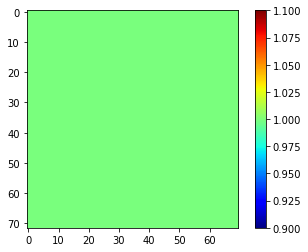

In [78]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
cmap = matplotlib.cm.jet
im = ax.imshow(mom0Masked,cmap=cmap)
fig.colorbar(im)
plt.show()

In [87]:
res = fluxMasked - np.mean(fluxMasked,axis=0)

In [96]:
res.shape

(241, 72, 70)

In [108]:
mom2 = np.sum(res**2.,axis=0) / len(fluxMasked)

In [106]:
mom1 = np.mean(fluxMasked,axis=0)

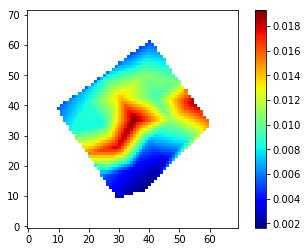

In [111]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
cmap = matplotlib.cm.jet
im = ax.imshow(mom1,cmap=cmap)
fig.colorbar(im)
ax.invert_yaxis()
plt.show()

In [21]:
from astropy.io import fits
modF = objectPathBase + 'modelInFits/'+objectNameBase+'_hdrEditVel.fits'
datF = objectPathBase + 'inFits/'+objectNameBase+'_hdrEditVel.fits'

col,row = 25,25
mod = fits.open(modF)['image'].data[:,col,row]
dat = fits.open(datF)['image'].data[:,col,row]

x = fits.open(fitsFile)['zCorrVels'].data

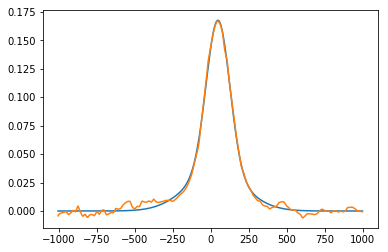

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(x,mod)
ax.plot(x,dat)

In [23]:
from astropy.io import fits
a = '/Volumes/QbertPrimary/umdResearch/adapProposalNearby/pySpecKitCube/run4/ngc253/1arc/3dBarolo/modelInFits/1342199415_ngc253_cii158_hdrEditVel.fits'
h = fits.open(a)

b = '/Volumes/QbertPrimary/umdResearch/adapProposalNearby/pySpecKitCube/run4/ngc253/1arc/3dBarolo/inFits/1342199415_ngc253_cii158_hdrEditVel.fits'
hb = fits.open(b)

In [25]:
h.info()

Filename: /Volumes/QbertPrimary/umdResearch/adapProposalNearby/pySpecKitCube/run4/ngc253/1arc/3dBarolo/modelInFits/1342199415_ngc253_cii158_hdrEditVel.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  image         1 PrimaryHDU      70   (68, 64, 2002)   float32   


In [26]:
h[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   68                                                  
NAXIS2  =                   64                                                  
NAXIS3  =                 2002                                                  
LONGSTRN= 'OGIP 1.0'           / The OGIP long string convention may be used.   
COMMENT This FITS file may contain long string keyword values that are          
COMMENT continued over multiple keywords.  This convention uses the  '&'        
COMMENT character at the end of a string which is then continued                
COMMENT on subsequent keywords whose name = 'CONTINUE'.                         
         -------------- Herschel Structure Data--------------------             
         Following fields ar